## 🧠 Alzheimer's Disease Classification
### The data in total consists of 6400 images.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

## DenseNet (ANN) Model

### Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

### Loading the dataset and data splitting into train,test and validation

In [9]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [10]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [11]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


### Model Building

In [14]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 4)                 602116    
                                                                 
 dense_5 (Dense)             (None, 8)                 40        
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
 activation (Activation)     (None, 4)                 0         
                                                                 
Total params: 602,368
Trainable params: 602,368
Non-tr

### F1 Score Function

In [24]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Model Metrics

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### Applying EarlyStopping and Model Checkpoint

In [26]:
filepath = './best_weights.hdf5'
earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint,lr_scheduler]

### Model Optimizers and loss function

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',), loss='categorical_crossentropy',metrics=METRICS)

### Fitting the model

In [28]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=callback_list)

Epoch 1/20
129/129 [==============================] - ETA: 0s - loss: 1.6183 - accuracy: 0.7457 - precision: 0.4854 - recall: 0.2831 - auc: 0.7521 - f1_score: 0.2852
Epoch 1: val_auc improved from -inf to 0.78038, saving model to ./best_weights.hdf5
129/129 [==============================] - 66s 498ms/step - loss: 1.6183 - accuracy: 0.7457 - precision: 0.4854 - recall: 0.2831 - auc: 0.7521 - f1_score: 0.2852 - val_loss: 1.0346 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.7509 - precision: 0.5039 - recall: 0.2206 - auc: 0.7779 - f1_score: 0.2226
Epoch 2: val_auc did not improve from 0.78038
129/129 [==============================] - 59s 458ms/step - loss: 1.0379 - accuracy: 0.7509 - precision: 0.5039 - recall: 0.2206 - auc: 0.7779 - f1_score: 0.2226 - val_loss: 1.0351 - val_accuracy: 0.7500 - val_precision: 0.

### Plotting model evalution

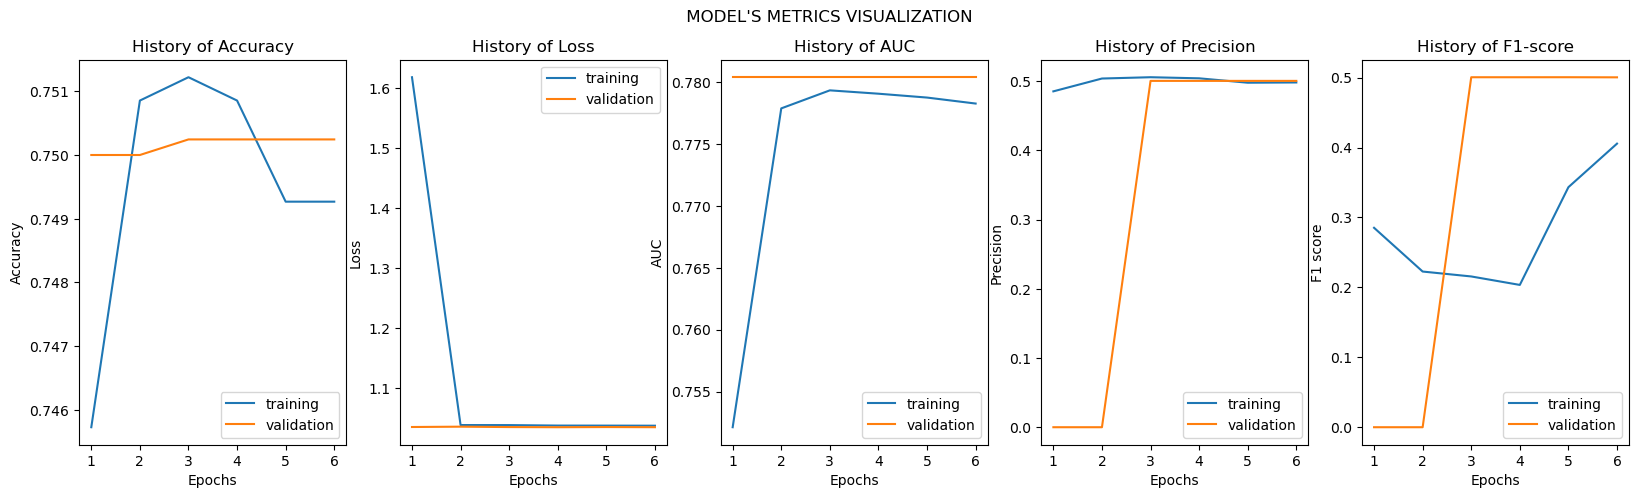

In [29]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )


### Model's Accuracy

In [30]:
scores = model.evaluate(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

40/40 [==============================] - 3s 67ms/step - loss: 1.0331 - accuracy: 0.7502 - precision: 0.5004 - recall: 0.5004 - auc: 0.7806 - f1_score: 0.5004
Accuracy =  0.7501954436302185
Precision =  0.5003909468650818
Recall =  0.5003909468650818
AUC =  0.7805577516555786
F1_score =  0.5004283785820007


## CNN Model

### Data Pre-Processing

In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['ModerateDemented', 'VeryMildDemented', 'MildDemented', 'NonDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

### Performing Image Augmentation to have more data samples

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


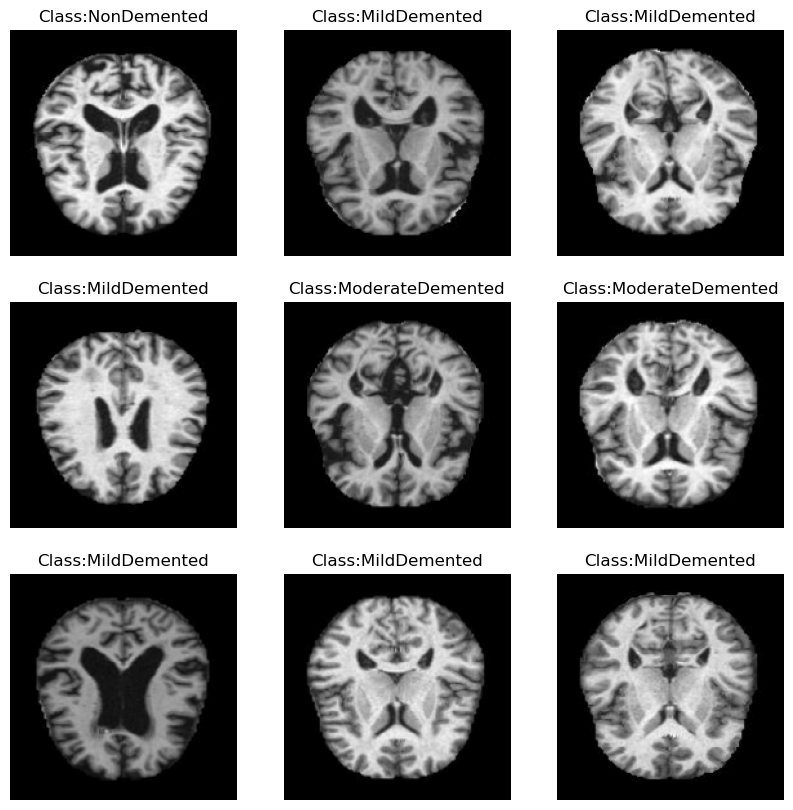

In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

### Retrieving the data from the ImageDataGenerator iterator

In [6]:
train_data, train_labels = train_data_gen.next()

### Getting to know the dimensions of our dataset

In [7]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


### Performing over-sampling of the data, since the classes are imbalanced

In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


### Splitting the data into train, test, and validation sets

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Constructing a Convolutional Neural Network Architecture

In [10]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [11]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

### Defining a custom callback function to stop training our model when accuracy goes above 99%
### EarlyStopping callback to make sure model is always learning

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

### Defining other parameters for our CNN model
### Like Loss functions, Metrics and Early Stopping

In [13]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

### Fit the training data to the model and validate it using the validation data

In [14]:
EPOCHS = 40

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/40


2023-04-01 16:56:58.789053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 28s 54ms/step - loss: 1.5713 - acc: 0.3423 - auc: 0.6075 - f1_score: 0.3380 - val_loss: 7.8177 - val_acc: 0.2402 - val_auc: 0.5065 - val_f1_score: 0.0969
Epoch 2/40
256/256 [==============================] - 12s 46ms/step - loss: 1.0500 - acc: 0.5283 - auc: 0.8022 - f1_score: 0.5173 - val_loss: 5.3069 - val_acc: 0.2402 - val_auc: 0.5082 - val_f1_score: 0.0969
Epoch 3/40
256/256 [==============================] - 12s 46ms/step - loss: 0.8096 - acc: 0.6311 - auc: 0.8796 - f1_score: 0.6240 - val_loss: 1.7460 - val_acc: 0.3701 - val_auc: 0.7119 - val_f1_score: 0.2749
Epoch 4/40
256/256 [==============================] - 12s 45ms/step - loss: 0.7456 - acc: 0.6635 - auc: 0.8981 - f1_score: 0.6581 - val_loss: 2.5047 - val_acc: 0.3638 - val_auc: 0.6763 - val_f1_score: 0.2432
Epoch 5/40
256/256 [==============================] - 12s 47ms/step - loss: 0.6735 - acc: 0.6953 - auc: 0.9162 - f1_score: 0.6913 - val_loss: 5.7100 - val_acc: 0.2568 - val_auc: 0

### Plotting the trend of the metrics during training

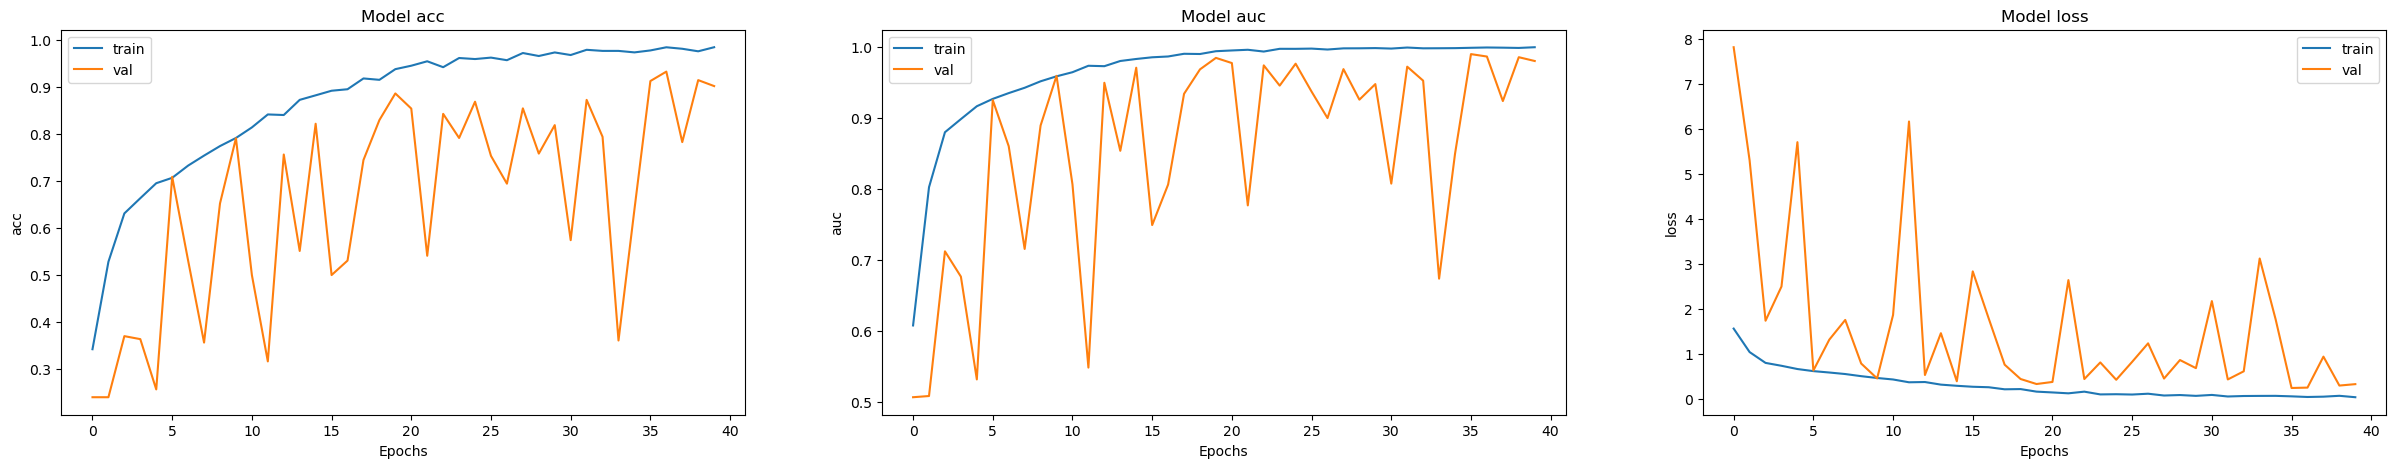

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Evaluating the model on the data

In [16]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 1s 15ms/step - loss: 0.3727 - acc: 0.9000 - auc: 0.9792 - f1_score: 0.8997
Testing Accuracy: 90.00%


### Predicting the test data

In [17]:
pred_labels = model.predict(test_data)

80/80 [==============================] - 1s 11ms/step


### Print the classification report of the tested data

In [18]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.96      0.96      0.96       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.95      0.70      0.80       662
ModerateDemented       0.74      0.95      0.83       624

       micro avg       0.90      0.90      0.90      2560
       macro avg       0.91      0.90      0.90      2560
    weighted avg       0.91      0.90      0.90      2560
     samples avg       0.90      0.90      0.90      2560



### Plot the confusion matrix to understand the classification in detail

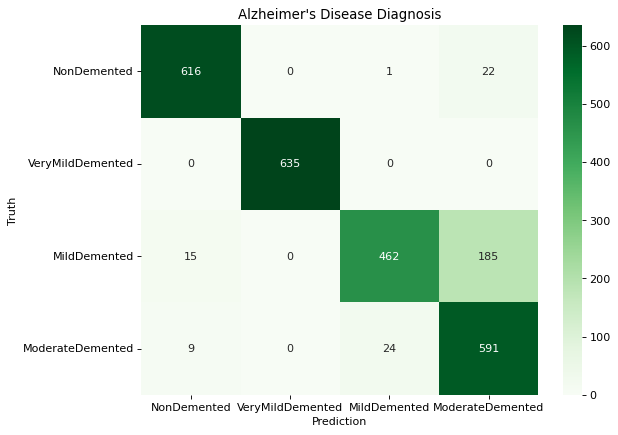

In [19]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)